# Spotify Song Prediction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Dependencies

In [4]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

##### Util classes

In [5]:
class ModelResultsLogger:
    def __init__(self):
        self.model_scores = {}

    def log_score(self, model_name, dataset_name, r2_score):
        if model_name not in self.model_scores:
            self.model_scores[model_name] = {}
        self.model_scores[model_name][dataset_name] = r2_score

    def plot_results(self):
        models = list(self.model_scores.keys())
        datasets = list(next(iter(self.model_scores.values())).keys())

        fig, ax = plt.subplots()
        bar_width = 0.35
        index = range(len(models))

        for i, dataset_name in enumerate(datasets):
            scores = [self.model_scores[model_name].get(dataset_name, None) for model_name in models]
            ax.bar([x + i * bar_width for x in index], scores, bar_width, label=dataset_name)

        ax.set_xlabel('Models')
        ax.set_ylabel('R2 Score')
        ax.set_title('Comparison of R2 Scores for Different Models and Datasets')
        ax.set_xticks([x + bar_width / 2 for x in index])
        ax.set_xticklabels(models)
        ax.legend()

        plt.show()

logger = ModelResultsLogger()

##### Loading the dataset

In [1]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/spotify_songs.csv')
df_two = pd.read_csv('/content/drive/MyDrive/Datasets/data_merged.csv')

df.head()


NameError: name 'pd' is not defined

In [7]:
df_two.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo', 'valence', 'year', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'minor', 'major', 'acousticness_ar', 'danceability_ar',
       'duration_ms_ar', 'energy_ar', 'instrumentalness_ar', 'liveness_ar',
       'loudness_ar', 'speechiness_ar', 'tempo_ar', 'valence_ar',
       'popularity_ar', 'count', 'key_0_ar', 'key_1_ar', 'key_2_ar',
       'key_3_ar', 'key_4_ar', 'key_5_ar', 'key_6_ar', 'key_7_ar', 'key_8_ar',
       'key_9_ar', 'key_10_ar', 'key_11_ar', 'minor_ar', 'major_ar',
       'acousticness_yr', 'danceability_yr', 'duration_ms_yr', 'energy_yr',
       'instrumentalness_yr', 'liveness_yr', 'loudness_yr', 'speechiness_yr',
       'tempo_yr', 'valence_yr', 'popularity_yr', 'mode', 'key_0_yr',
       'key_1_yr', 'key_2_yr', 'key_3_yr', 'ke

##### Dropping invalid and missing values

In [8]:
columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(axis=0, inplace=True)

# df = df[df['track_popularity'] < 15]

rows_to_drop = df.loc[df['duration_ms'] < 20000].index
df.drop(rows_to_drop, inplace=True)

new_df = df.copy()

# Assuming 'date' is a string column in the format 'YYYY-MM-DD'
new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# Convert the columns to numeric (to handle missing values during median calculation)
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')
# new_df['month'] = pd.to_numeric(new_df['month'], errors='coerce', downcast='integer')
# new_df['day'] = pd.to_numeric(new_df['day'], errors='coerce', downcast='integer')

# Calculate median values for year, month, and day
median_year = int(new_df['year'].median())
# median_month = int(new_df['month'].median())
# median_day = int(new_df['day'].median())

# Fill missing values with median values
new_df['year'] = new_df['year'].fillna(median_year).astype(int)
# new_df['month'] = new_df['month'].fillna(median_month).astype(int)
# new_df['day'] = new_df['day'].fillna(median_day).astype(int)

X = new_df.drop(['track_popularity', 'track_album_release_date', 'month', 'day'], axis=1)
# X.columns

X = pd.get_dummies(X, dtype=int)
X['year'] = new_df['year']
y = new_df['track_popularity']

#New data set
X_two = df_two.drop(columns=['popularity'])
y_two = df_two['popularity']


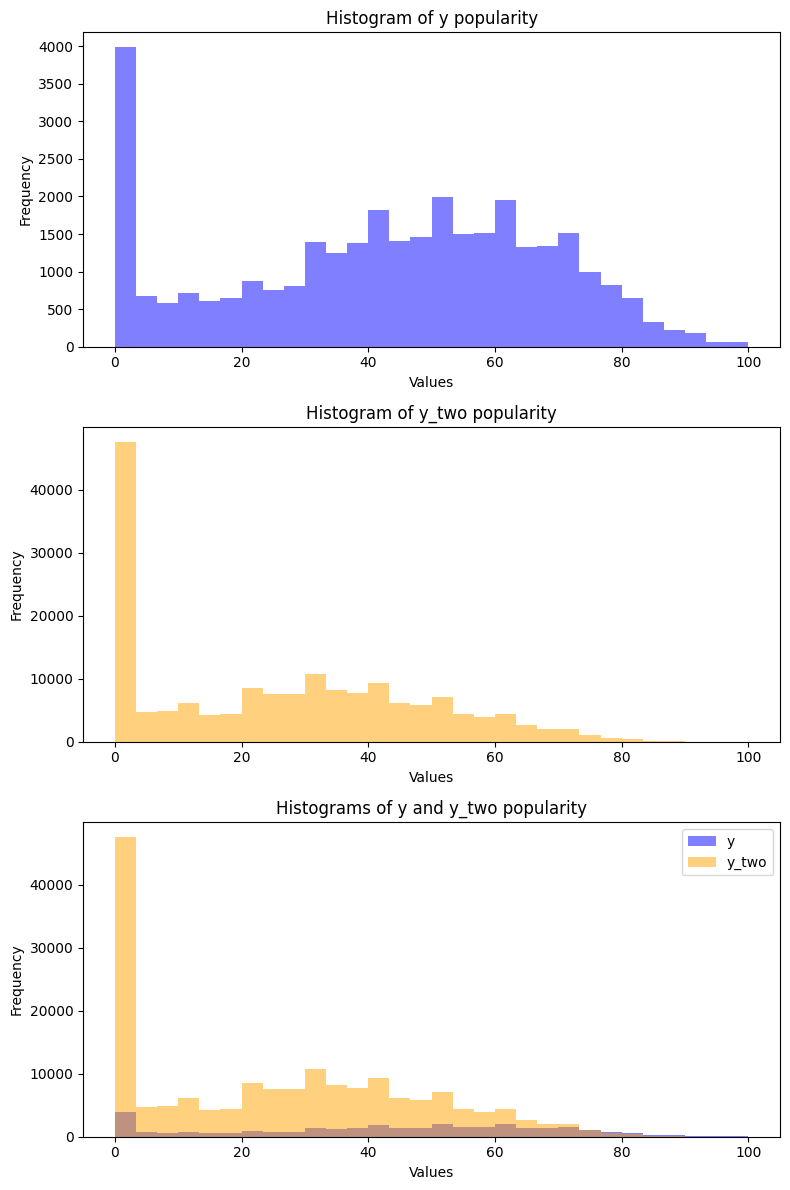

In [9]:


fig, axes = plt.subplots(3, 1, figsize=(8, 12))

axes[0].hist(y, bins=30, alpha=0.5, color='blue')
axes[0].set_title('Histogram of y popularity')

axes[1].hist(y_two, bins=30, alpha=0.5, color='orange')
axes[1].set_title('Histogram of y_two popularity')

axes[2].hist(y, bins=30, alpha=0.5, color='blue', label='y')
axes[2].hist(y_two, bins=30, alpha=0.5, color='orange', label='y_two')
axes[2].set_title('Histograms of y and y_two popularity')

axes[2].legend()

for ax in axes:
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# X.tail()
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

In [11]:
df.iloc[3446]
X.iloc[3446]

danceability                                        0.63000
energy                                              0.52600
key                                                 7.00000
loudness                                           -9.12100
mode                                                1.00000
speechiness                                         0.03890
acousticness                                        0.31600
instrumentalness                                    0.00538
liveness                                            0.07470
valence                                             0.61000
tempo                                             145.27100
duration_ms                                    215333.00000
year                                             1981.00000
playlist_genre_edm                                  0.00000
playlist_genre_latin                                0.00000
playlist_genre_pop                                  1.00000
playlist_genre_r&b                      

##### Splitting the dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_two, X_test_two, y_trian_two, y_test_two = train_test_split(X_two, y_two, test_size=0.05, random_state=42)

In [13]:
X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
count,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,...,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000,32832.000000
mean,0.654869,0.698631,5.374604,-6.718909,0.565698,0.107071,0.175339,0.084750,0.190182,0.510577,...,0.034509,0.033656,0.046205,0.034387,0.055099,0.028905,0.051017,0.039321,0.039230,0.042794
std,0.145043,0.180900,3.611632,2.986570,0.495673,0.101314,0.219634,0.224233,0.154316,0.233132,...,0.182535,0.180345,0.209932,0.182224,0.228176,0.167541,0.220036,0.194361,0.194145,0.202395
min,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
print(X.columns)

numeric_feats = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
dummy_feats = [feat for feat in X.columns if feat not in numeric_feats]

print(X[numeric_feats])

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'year', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subge

<Axes: >

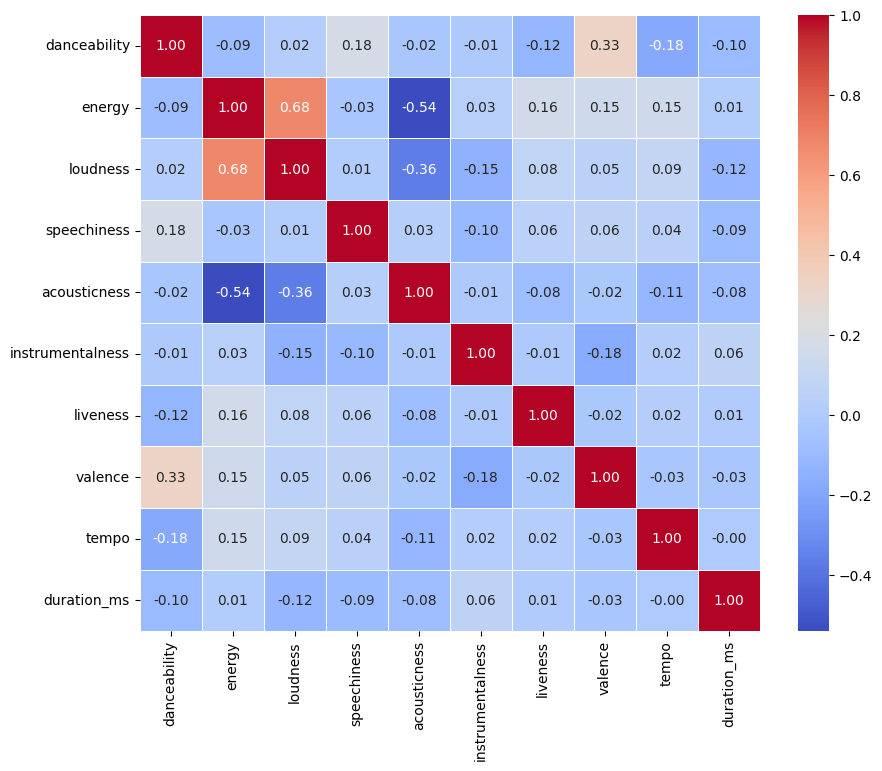

In [15]:
numeric_values = df[numeric_feats]
correlation_matrix = numeric_values.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [16]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1 - ((1 - r2) * (N - 1)) / (N - d - 1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res = pd.concat([pd.DataFrame(y_test.values),
                    pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse, mae, rmse, r2, r2_adj

##### Scaling the data

In [17]:
s = StandardScaler()

s.fit(X_train[numeric_feats])
X_train_std = s.transform(X_train[numeric_feats])
X_test_std = s.transform(X_test[numeric_feats])
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)

X_train_std = pd.concat([X_train_std, X_train[dummy_feats].reset_index(drop=True)], axis=1)
X_test_std = pd.concat([X_test_std, X_test[dummy_feats].reset_index(drop=True)], axis=1)

X_train_std.columns = list(X.columns)
X_test_std.columns = list(X.columns)
X_train_std.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
0,-1.475185,0.299901,0.885663,-0.623145,-0.478061,-0.378039,-1.057780,-1.100957,0.525789,0.565481,...,0,0,1,0,0,0,0,0,0,0
1,0.352463,0.476752,0.081846,1.620841,-0.737502,-0.378039,-0.169845,-0.573133,1.456620,0.654139,...,0,0,0,0,0,0,1,0,0,0
2,1.711131,-0.993323,-1.134759,1.976716,-0.666952,-0.373994,0.893085,0.366652,-0.718915,2.088656,...,0,0,0,0,0,0,1,0,0,0
3,0.159353,-0.617514,-0.012228,3.093766,-0.761534,3.818733,2.286561,-1.409927,0.190745,0.014551,...,0,0,0,0,0,0,0,0,0,0
4,-0.364803,-1.778100,0.169560,-0.617214,2.530086,-0.378039,-0.709087,0.031934,-1.748938,-0.517483,...,0,0,0,0,0,0,0,0,0,0


In [18]:
s.fit(X_train_two)
X_train_two_std = s.transform(X_train_two)
X_test_two_std = s.transform(X_test_two)
X_train_two_std = pd.DataFrame(X_train_two_std)
X_test_two_std = pd.DataFrame(X_test_two_std)


In [19]:
# folds = KFold(n_splits=5, shuffle=True, random_state=42)
# hyper_params = [{'n_features_to_select': list(range(1, 16))}]

# lm = LinearRegression()
# lm.fit(X_train_std, y_train)
# rfe = RFE(lm)

# model_cv = GridSearchCV(
#     estimator=rfe,
#     param_grid=hyper_params,
#     scoring='r2',
#     cv=folds,
#     verbose=1,
#     return_train_score=True
# )

# model_cv.fit(X_train_std, y_train)
# cv_results = pd.DataFrame(model_cv.cv_results_)
# cv_results

In [20]:
# # plotting cv results
# plt.figure(figsize=(16,6))

# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
# plt.xlabel('number of features')
# plt.ylabel('r-squared')
# plt.title("Optimal Number of Features")
# plt.legend(['test score', 'train score'], loc='upper left')

### Linear Regression

#### Base LR

In [21]:
lrm = LinearRegression()

##### Data Set 1

In [22]:
# final model
n_features_optimal = 13

lrm.fit(X_train_std, y_train)

# predict prices of X_test
y_pred = lrm.predict(X_test_std)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("r2:", r2)
print("mse", mse)
logger.log_score('linearRegression', 'ds1', r2)

model_evaluation(y_test, y_pred, X_train_std.shape[0], X_train_std.shape[1])

r2: 0.15629389499103952
mse 499.00005447734935
Mean squared error:  499.00005447734935
Mean absolute error:  18.387517486538723
Root mean squared error:  22.338309123059187
R2 score:  0.15629389499103952
R2 adjusted score:  0.15512907888253813
     y     y_pred
0   42  44.763626
1   64  54.434412
2   40  49.673538
3   41  15.610120
4   27  34.414180
5   55  55.227887
6    0  53.444385
7    0  47.393108
8   40  40.801519
9   50  37.131372
10   1  42.851164
11  32  52.855173
12  67  58.138643
13  63  33.160243
14  53  55.590951
15  42  37.885482
16  53  51.814999
17  80  41.256565
18  62  43.199856
19   2  47.381341


(499.00005447734935,
 18.387517486538723,
 22.338309123059187,
 0.15629389499103952,
 0.15512907888253813)

##### Data Set 2

In [23]:

lrm.fit(X_train_two, y_trian_two)

# predict prices of X_test
y_pred_two = lrm.predict(X_test_two)
r2 = r2_score(y_test_two, y_pred_two)
mse = mean_squared_error(y_test_two, y_pred_two)
print("r2:", r2)
print("mse", mse)
logger.log_score('linearRegression', 'ds2', r2)

model_evaluation(y_test_two, y_pred_two, X_train_two.shape[0], X_train_two.shape[1])

r2: 0.8298596707098354
mse 80.64295679396044
Mean squared error:  80.64295679396044
Mean absolute error:  6.216718824542466
Root mean squared error:  8.980142359337096
R2 score:  0.8298596707098354
R2 adjusted score:  0.829785807922732
     y     y_pred
0   25  15.500726
1   53  54.655095
2   65  57.663659
3   16  28.466103
4   14  17.906173
5   19  27.373398
6    0   1.165641
7    0  -4.546895
8   49  49.264875
9    6  10.782425
10  67  47.438293
11  59  49.660454
12  45  42.112948
13  26  31.740188
14  74  64.763908
15  31  33.623518
16   0   4.415320
17  54  49.755228
18  16  20.809041
19  26  27.022908


(80.64295679396044,
 6.216718824542466,
 8.980142359337096,
 0.8298596707098354,
 0.829785807922732)

#### Base Lasso

In [24]:
lm = Lasso(alpha=0.01)

##### Data set 1

Mean squared error:  499.18942100913165
Mean absolute error:  18.400997080639073
Root mean squared error:  22.342547325878748
R2 score:  0.1559737152685815
R2 adjusted score:  0.15480845712167812
     y     y_pred
0   42  44.860901
1   64  54.062243
2   40  49.884564
3   41  15.459901
4   27  34.658925
5   55  54.938405
6    0  53.107366
7    0  47.406468
8   40  41.047383
9   50  37.385789
10   1  42.970216
11  32  52.673105
12  67  57.910029
13  63  33.408149
14  53  55.271331
15  42  37.914109
16  53  51.570958
17  80  41.354724
18  62  43.405841
19   2  47.078927
koeficijenti:  [ 1.43496138e+00 -4.66811262e+00  4.17904168e+00  4.88082461e-02
  1.07760290e-01 -2.16755921e+00 -3.22203158e-01 -4.86393077e-01
  3.03756948e-01 -1.72797751e+00  4.18470490e-02  9.27879641e-03
 -9.41247126e-02 -4.00017841e+00  3.64751456e-01  1.02897443e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.66302529e+00
 -3.34405289e+00  0.00000000e+00  7.36440267e+00 -0.00000000e+00
 -0.00000000e+00 -9.5

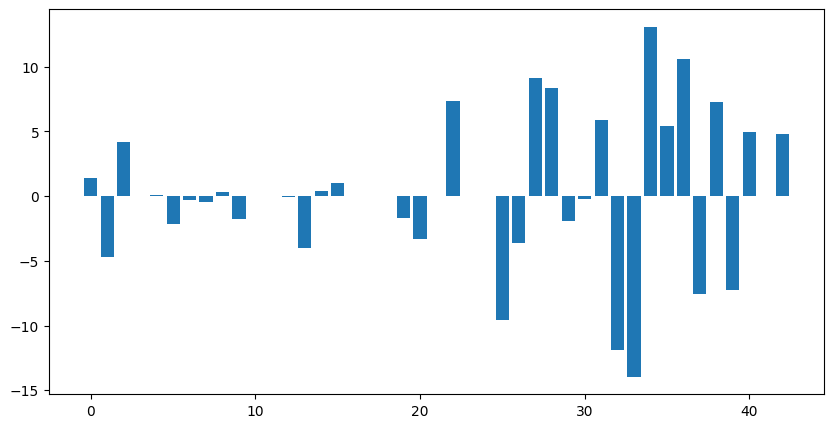

In [25]:

#Obuka
lm.fit(X_train_std, y_train)

# Testiranje
y_predicted = lm.predict(X_test_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lm.coef_)),lm.coef_)
print("koeficijenti: ", lm.coef_)
logger.log_score('Lasso', 'ds1', r2)

##### Data set 2

Mean squared error:  80.73327418546964
Mean absolute error:  6.213536540771464
Root mean squared error:  8.98516968039389
R2 score:  0.8296691192798913
R2 adjusted score:  0.8295951737689577
     y     y_pred
0   25  15.524826
1   53  54.733443
2   65  58.384181
3   16  28.331656
4   14  17.948619
5   19  27.590770
6    0   1.144925
7    0  -4.544302
8   49  49.378748
9    6  10.917794
10  67  47.565202
11  59  49.578659
12  45  42.233865
13  26  31.579296
14  74  64.574343
15  31  33.676443
16   0   4.591833
17  54  49.698071
18  16  20.838251
19  26  27.302481
koeficijenti:  [-3.46957185e-01  5.95406931e-01  1.93100967e-01 -1.94110330e-02
  1.75212275e-01 -1.85340434e-01 -5.44247163e-01  2.46470075e-01
 -8.44053393e-01  3.60706711e-02 -1.92276577e-02 -1.01722815e+00
  0.00000000e+00  8.18498263e-02 -3.63145646e-02  0.00000000e+00
  2.91188830e-02 -1.54338104e-02  7.17952943e-02 -2.52468895e-02
  6.26334556e-02 -3.73309254e-02 -1.11021891e-02  1.45867754e-02
  1.05221863e-01 -2.821013

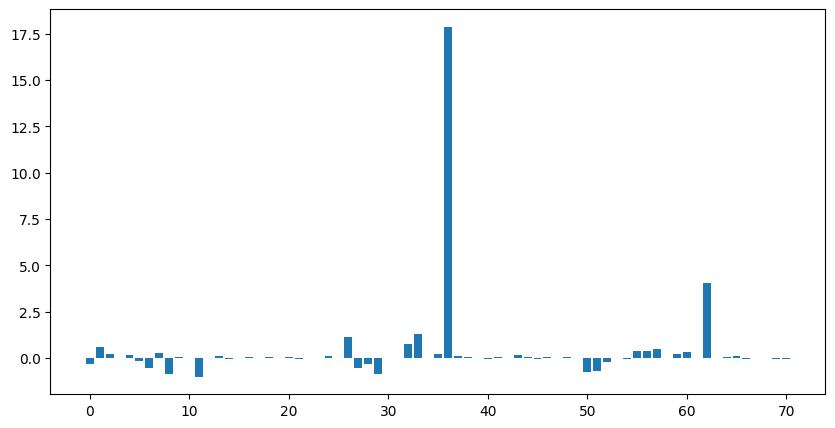

In [26]:
#Obuka
lm.fit(X_train_two_std, y_trian_two)

# Testiranje
y_predicted = lm.predict(X_test_two_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test_two, y_predicted, X_train_two_std.shape[0], X_train_two_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lm.coef_)),lm.coef_)
print("koeficijenti: ", lm.coef_)
logger.log_score('Lasso', 'ds2', r2)

#### Base Ridge

In [27]:
# Inicijalizacija modela
rm = Ridge(alpha=5)

##### Data set 1

Mean squared error:  499.01872388768123
Mean absolute error:  18.38912666624824
Root mean squared error:  22.33872699792182
R2 score:  0.15626232887129154
R2 adjusted score:  0.155097469182775
     y     y_pred
0   42  44.784573
1   64  54.404420
2   40  49.698066
3   41  15.588815
4   27  34.447868
5   55  55.193123
6    0  53.406188
7    0  47.404481
8   40  40.828278
9   50  37.170170
10   1  42.864395
11  32  52.850784
12  67  58.094433
13  63  33.194933
14  53  55.554266
15  42  37.888658
16  53  51.800474
17  80  41.274481
18  62  43.222430
19   2  47.359646
koeficijenti:  [  1.44215682  -4.66186621   4.19015691   0.07436784   0.09360586
  -2.16397253  -0.3214988   -0.5289383    0.30903501  -1.71361023
   0.04443929   0.04691602  -0.10169585  -4.52531402   2.8065247
   3.92545147  -2.73301518  -0.72677786   1.2531309   -3.57747579
  -3.31522334  -1.59054545   4.50814161   0.30250297  -3.11959965
  -9.32805506  -5.347514     9.90747451  11.11436065  -5.18471088
  -3.04660282   3.5

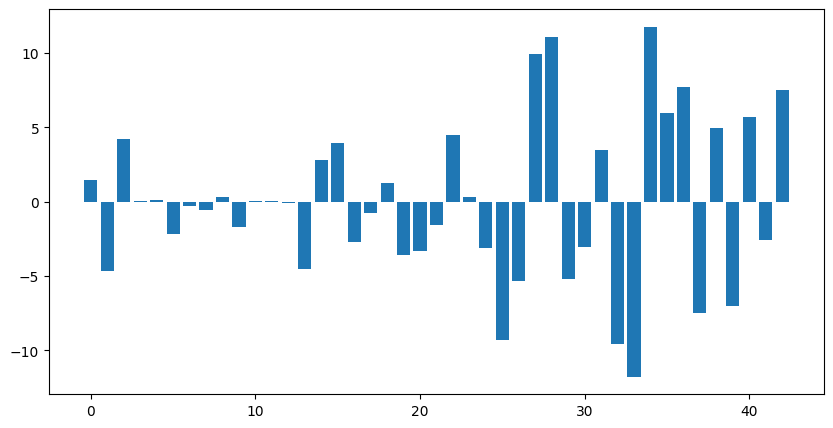

In [28]:
#Obuka
rm.fit(X_train_std, y_train)

# Testiranje
y_predicted = rm.predict(X_test_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test, y_predicted, X_train_std.shape[0], X_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)
logger.log_score('Ridge', 'ds1', r2)

##### Data set 2

Mean squared error:  80.6432629675418
Mean absolute error:  6.216757039019858
Root mean squared error:  8.980159406577469
R2 score:  0.8298590247455003
R2 adjusted score:  0.8297851616779655
     y     y_pred
0   25  15.501266
1   53  54.653840
2   65  57.664044
3   16  28.466380
4   14  17.905747
5   19  27.374155
6    0   1.166125
7    0  -4.546559
8   49  49.264575
9    6  10.783794
10  67  47.437610
11  59  49.659499
12  45  42.113448
13  26  31.740646
14  74  64.762357
15  31  33.622864
16   0   4.418179
17  54  49.754160
18  16  20.809736
19  26  27.023388
koeficijenti:  [-4.48336107e-01  6.84562847e-01  2.21079527e-01 -2.67798751e-02
  1.84683334e-01 -2.45920216e-01 -5.55164680e-01  2.34989418e-01
 -1.02341635e+00  6.17532190e-02 -9.66664372e-02 -1.49153815e+00
 -8.47092166e-03  8.49746197e-02 -5.07888679e-02 -6.46083200e-03
  3.35347772e-02 -3.71311360e-02  7.38615892e-02 -4.08477191e-02
  6.33728137e-02 -5.33304121e-02 -3.09174733e-02  2.05416619e-02
  5.90267761e-02 -5.902677

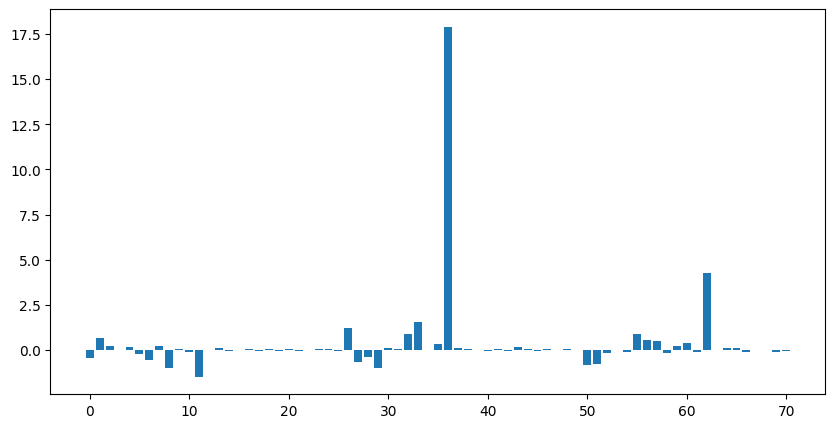

In [29]:
#Obuka
rm.fit(X_train_two_std, y_trian_two)

# Testiranje
y_predicted = rm.predict(X_test_two_std)

# Evaluacija (racunanje mera uspesnosti)
_, _, _, r2, _ = model_evaluation(y_test_two, y_predicted, X_train_two_std.shape[0], X_train_two_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)
logger.log_score('Ridge', 'ds2', r2)

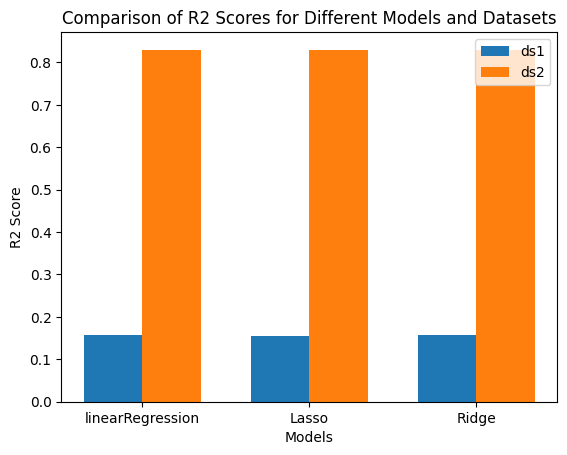

In [30]:
logger.plot_results()

##### Poly hypothesis

In [31]:
poly = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)
poly_two = PolynomialFeatures(interaction_only=False, degree=2, include_bias=True)

X_inter_train = poly.fit_transform(X_train_std)
X_inter_test = poly.transform(X_test_std)

X_inter_two_train = poly_two.fit_transform(X_train_two_std)
X_inter_two_test = poly_two.transform(X_test_two_std)

out_feat_names = PolynomialFeatures.get_feature_names_out(
    poly, input_features=None)

out_feat_names_two = PolynomialFeatures.get_feature_names_out(
    poly_two, input_features=None)

In [32]:
# def standardizacija(x_train, x_test, numeric_feats, dummy_feats):
#     # Save the original order of columns
#     cols = x_train.columns

#     # Standardize numeric features
#     s = StandardScaler()
#     s.fit(x_train[numeric_feats])

#     x_train_std_numeric = s.transform(x_train[numeric_feats])
#     x_test_std_numeric = s.transform(x_test[numeric_feats])

#     x_train_std_numeric = pd.DataFrame(x_train_std_numeric, columns=numeric_feats)
#     x_test_std_numeric = pd.DataFrame(x_test_std_numeric, columns=numeric_feats)

#     # Concatenate standardized numeric features with dummy features
#     x_train_std = pd.concat([x_train_std_numeric, x_train[dummy_feats]], axis=1)
#     x_test_std = pd.concat([x_test_std_numeric, x_test[dummy_feats]], axis=1)

#     return x_train_std_numeric, x_test_std_numeric

In [33]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

# # Define number of folds
# k = 5
# kf = KFold(n_splits=k, shuffle=True, random_state=42)

# # Initialize lists to store performance metrics
# mse_scores = []
# r2_scores = []

# model = Lasso(alpha=0.01)

# # Iterate over each fold
# for train_index, test_index in kf.split(X_train_std):
#     # Split data into train and test sets for this fold
#     X_train_fold, X_val_fold = X_train_std.iloc[train_index], X_train_std.iloc[test_index]
#     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#     # Train your model on the training fold
#     model.fit(X_train_fold, y_train_fold)

#     # Make predictions on the validation fold
#     y_pred = model.predict(X_val_fold)

#     # Compute performance metrics for this fold
#     mse = mean_squared_error(y_val_fold, y_pred)
#     r2 = r2_score(y_val_fold, y_pred)

#     # Append scores to lists
#     mse_scores.append(mse)
#     r2_scores.append(r2)

# # Compute average performance metrics over all folds
# avg_mse = np.mean(mse_scores)
# avg_r2 = np.mean(r2_scores)

# print("Average MSE:", avg_mse)
# print("Average R-squared:", avg_r2)


#### LR Poly

In [34]:
# final model
n_features_optimal = 13
lrm = LinearRegression()

##### Data set 1

In [35]:

lrm.fit(X_inter_train, y_train)

# predict prices of X_test
y_pred = lrm.predict(X_inter_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("r2:", r2)
print("mse", mse)
logger.log_score('LR Poly', 'ds1', r2)

model_evaluation(y_test, y_pred, X_train_std.shape[0], X_train_std.shape[1])

r2: 0.2087544462516815
mse 467.97287832968584
Mean squared error:  467.97287832968584
Mean absolute error:  17.65796571874242
Root mean squared error:  21.632680793874943
R2 score:  0.2087544462516815
R2 adjusted score:  0.20766205689795458
     y     y_pred
0   42  42.434898
1   64  33.134501
2   40  50.223869
3   41  20.646830
4   27  29.449513
5   55  53.113432
6    0  44.792453
7    0  46.081704
8   40  34.726713
9   50  42.585551
10   1  28.696828
11  32  52.347690
12  67  66.211179
13  63  38.796501
14  53  53.695232
15  42  38.591151
16  53  54.346997
17  80  34.102472
18  62  41.119191
19   2  39.292721


(467.97287832968584,
 17.65796571874242,
 21.632680793874943,
 0.2087544462516815,
 0.20766205689795458)

##### Data set 2

In [36]:

lrm.fit(X_inter_two_train, y_trian_two)

# predict prices of X_test
y_pred = lrm.predict(X_inter_two_test)
r2 = r2_score(y_test_two, y_pred_two)
mse = mean_squared_error(y_test_two, y_pred_two)
print("r2:", r2)
print("mse", mse)
logger.log_score('LR Poly', 'ds2', r2)

model_evaluation(y_test_two, y_pred_two, X_train_two_std.shape[0], X_train_two_std.shape[1])

r2: 0.8298596707098354
mse 80.64295679396044
Mean squared error:  80.64295679396044
Mean absolute error:  6.216718824542466
Root mean squared error:  8.980142359337096
R2 score:  0.8298596707098354
R2 adjusted score:  0.829785807922732
     y     y_pred
0   25  15.500726
1   53  54.655095
2   65  57.663659
3   16  28.466103
4   14  17.906173
5   19  27.373398
6    0   1.165641
7    0  -4.546895
8   49  49.264875
9    6  10.782425
10  67  47.438293
11  59  49.660454
12  45  42.112948
13  26  31.740188
14  74  64.763908
15  31  33.623518
16   0   4.415320
17  54  49.755228
18  16  20.809041
19  26  27.022908


(80.64295679396044,
 6.216718824542466,
 8.980142359337096,
 0.8298596707098354,
 0.829785807922732)

#### Lasso Poly

In [37]:
# Define hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# Instantiate Lasso regression model
lasso = Lasso()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

##### Data set 1

Mean squared error:  499.0138928823167
Mean absolute error:  18.388708215474413
Root mean squared error:  22.338618866937964
R2 score:  0.15627049710430618
R2 adjusted score:  0.1551056486928083
     y     y_pred
0   42  44.773362
1   64  54.397209
2   40  49.694640
3   41  15.595135
4   27  34.438669
5   55  55.198930
6    0  53.410699
7    0  47.394462
8   40  40.826089
9   50  37.156782
10   1  42.862894
11  32  52.836973
12  67  58.115774
13  63  33.185025
14  53  55.558997
15  42  37.888397
16  53  51.790592
17  80  41.266390
18  62  43.220456
19   2  47.351130
koeficijenti:  [-4.48336107e-01  6.84562847e-01  2.21079527e-01 -2.67798751e-02
  1.84683334e-01 -2.45920216e-01 -5.55164680e-01  2.34989418e-01
 -1.02341635e+00  6.17532190e-02 -9.66664372e-02 -1.49153815e+00
 -8.47092166e-03  8.49746197e-02 -5.07888679e-02 -6.46083200e-03
  3.35347772e-02 -3.71311360e-02  7.38615892e-02 -4.08477191e-02
  6.33728137e-02 -5.33304121e-02 -3.09174733e-02  2.05416619e-02
  5.90267761e-02 -5.90

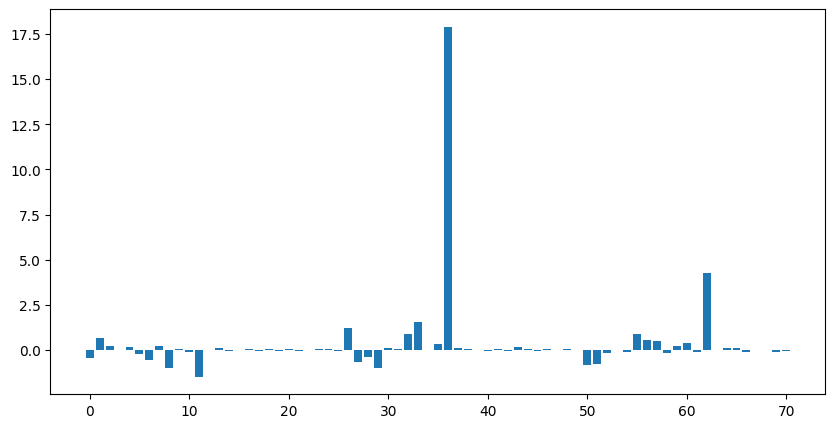

In [38]:
# Fit grid search to training data
grid_search.fit(X_train_std, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

model_evaluation(y_test, y_pred, X_train_std.shape[0], X_train_std.shape[1])

# Ilustracija koeficijenata
logger.log_score('Lasso Poly', 'ds1', r2)
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)

##### Data set 2

Mean squared error:  80.65060065743167
Mean absolute error:  6.216152952327029
Root mean squared error:  8.980567947375693
R2 score:  0.8298435437038357
R2 adjusted score:  0.8297696739155375
     y     y_pred
0   25  15.498887
1   53  54.667631
2   65  57.737826
3   16  28.462567
4   14  17.906936
5   19  27.396444
6    0   1.165343
7    0  -4.535568
8   49  49.283727
9    6  10.796547
10  67  47.455192
11  59  49.655659
12  45  42.127939
13  26  31.738981
14  74  64.739163
15  31  33.616313
16   0   4.448676
17  54  49.749744
18  16  20.813890
19  26  27.052856
koeficijenti:  [-4.48336107e-01  6.84562847e-01  2.21079527e-01 -2.67798751e-02
  1.84683334e-01 -2.45920216e-01 -5.55164680e-01  2.34989418e-01
 -1.02341635e+00  6.17532190e-02 -9.66664372e-02 -1.49153815e+00
 -8.47092166e-03  8.49746197e-02 -5.07888679e-02 -6.46083200e-03
  3.35347772e-02 -3.71311360e-02  7.38615892e-02 -4.08477191e-02
  6.33728137e-02 -5.33304121e-02 -3.09174733e-02  2.05416619e-02
  5.90267761e-02 -5.90267

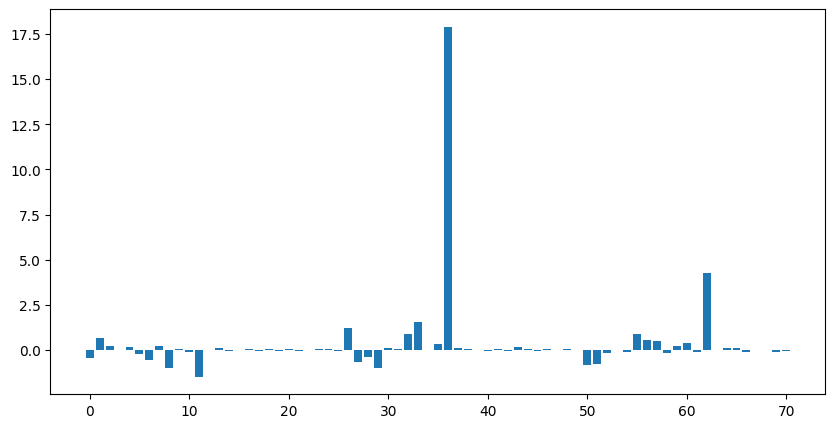

In [39]:
# Fit grid search to training data
grid_search.fit(X_train_two_std, y_trian_two)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_two_std)
mse = mean_squared_error(y_test_two, y_pred)
r2 = r2_score(y_test_two, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

model_evaluation(y_test_two, y_pred, X_train_two_std.shape[0], X_train_two_std.shape[1])


# Ilustracija koeficijenata
logger.log_score('Lasso Poly', 'ds2', r2)
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)

#### Ridge Poly

In [40]:
# Define hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 5, 10.0, 100.0]}

# Instantiate ridge regression model
ridge = Ridge()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

##### Data set 1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.51222e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.46924e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.51093e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.50239e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

Mean squared error:  467.7913308000368
Mean absolute error:  17.653125028326627
Root mean squared error:  21.628484246475452
R2 score:  0.20906140565527231
R2 adjusted score:  0.18313242759635373
     y     y_pred
0   42  42.437693
1   64  33.724332
2   40  50.294620
3   41  19.969664
4   27  29.408703
5   55  53.101052
6    0  44.772773
7    0  46.129198
8   40  34.735759
9   50  42.598989
10   1  28.666283
11  32  52.342281
12  67  66.140495
13  63  38.822451
14  53  53.675312
15  42  38.827882
16  53  54.347514
17  80  34.129307
18  62  41.118048
19   2  39.256444
koeficijenti:  [-4.48336107e-01  6.84562847e-01  2.21079527e-01 -2.67798751e-02
  1.84683334e-01 -2.45920216e-01 -5.55164680e-01  2.34989418e-01
 -1.02341635e+00  6.17532190e-02 -9.66664372e-02 -1.49153815e+00
 -8.47092166e-03  8.49746197e-02 -5.07888679e-02 -6.46083200e-03
  3.35347772e-02 -3.71311360e-02  7.38615892e-02 -4.08477191e-02
  6.33728137e-02 -5.33304121e-02 -3.09174733e-02  2.05416619e-02
  5.90267761e-02 -5.9

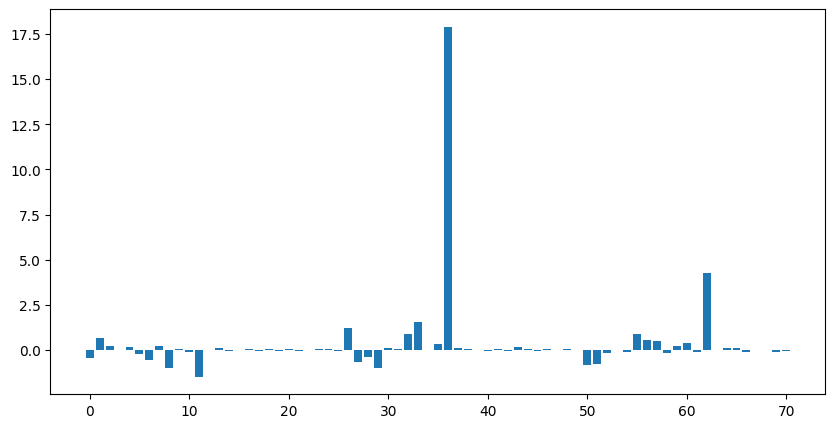

In [41]:
# Fit grid search to training data
grid_search.fit(X_inter_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_inter_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

logger.log_score('Ridge Poly', 'ds1', r2)
model_evaluation(y_test, y_pred, X_inter_train.shape[0], X_inter_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)

##### Data set 2

Mean squared error:  80.64295679396044
Mean absolute error:  6.216718824542466
Root mean squared error:  8.980142359337096
R2 score:  0.8298596707098354
R2 adjusted score:  0.8270822835257758
     y     y_pred
0   25  15.500726
1   53  54.655095
2   65  57.663659
3   16  28.466103
4   14  17.906173
5   19  27.373398
6    0   1.165641
7    0  -4.546895
8   49  49.264875
9    6  10.782425
10  67  47.438293
11  59  49.660454
12  45  42.112948
13  26  31.740188
14  74  64.763908
15  31  33.623518
16   0   4.415320
17  54  49.755228
18  16  20.809041
19  26  27.022908
koeficijenti:  [-4.48336107e-01  6.84562847e-01  2.21079527e-01 -2.67798751e-02
  1.84683334e-01 -2.45920216e-01 -5.55164680e-01  2.34989418e-01
 -1.02341635e+00  6.17532190e-02 -9.66664372e-02 -1.49153815e+00
 -8.47092166e-03  8.49746197e-02 -5.07888679e-02 -6.46083200e-03
  3.35347772e-02 -3.71311360e-02  7.38615892e-02 -4.08477191e-02
  6.33728137e-02 -5.33304121e-02 -3.09174733e-02  2.05416619e-02
  5.90267761e-02 -5.90267

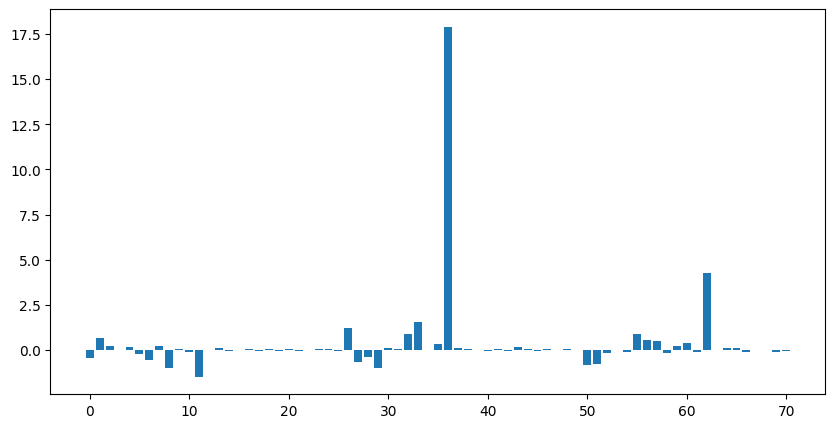

In [42]:
# Fit grid search to training data
grid_search.fit(X_inter_two_train, y_trian_two)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_inter_two_test)
mse = mean_squared_error(y_test_two, y_pred)
r2 = r2_score(y_test_two, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

logger.log_score('Ridge Poly', 'ds2', r2)
model_evaluation(y_test_two, y_pred_two, X_inter_two_train.shape[0], X_inter_two_train.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(rm.coef_)),rm.coef_)
print("koeficijenti: ", rm.coef_)

In [3]:
logger.plot_results()

NameError: name 'logger' is not defined

In [2]:
for score in logger.model_scores:
  print(score['b1'])

NameError: name 'logger' is not defined

### SVR

In [44]:
# from sklearn.svm import SVR
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 1],
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'degree': [2, 3, 4]
# }

# # Instantiate SVR
# svr = SVR()

# # Instantiate RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

##### Data set 1

In [45]:
# # Fit random search to training data
# random_search.fit(X_train_std, y_train)

# # Access best model and parameters
# best_model = random_search.best_estimator_
# best_params = random_search.get_params

# # Evaluate best model on testing data
# y_pred = best_model.predict(X_test_std)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# logger.log_score('SVR', 'ds1', r2)
# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

##### Data set 2

In [46]:
# Fit random search to training data
random_search.fit(X_train_two_std, y_trian_two)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.get_params

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_two_std)
mse = mean_squared_error(y_test_two, y_pred)
r2 = r2_score(y_test_two, y_pred)

logger.log_score('SVR', 'ds2', r2)
print("Best Model Parameters:", best_params)
print("MSE:", mse)
print("R-squared:", r2)

NameError: name 'random_search' is not defined

### RFR

In [ ]:
# df = pd.read_csv('spotify_songs.csv')
# columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id', 'playlist_subgenre', 'playlist_genre']
# df.drop(columns=columns_to_drop, inplace=True)
# df.dropna(axis=0, inplace=True)

# # df = df[df['track_popularity'] < 15]

# rows_to_drop = df.loc[df['duration_ms'] < 20000].index
# df.drop(rows_to_drop, inplace=True)

# new_df = df.copy()

# # Assuming 'date' is a string column in the format 'YYYY-MM-DD'
# new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# # Convert the columns to numeric (to handle missing values during median calculation)
# new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')

# # Calculate median values for year, month, and day
# median_year = int(new_df['year'].median())

# # Fill missing values with median values
# new_df['year'] = new_df['year'].fillna(median_year).astype(int)

# X = new_df.drop(['track_popularity', 'track_album_release_date', 'month', 'day'], axis=1)
# # X.columns

# X = pd.get_dummies(X, dtype=int)
# X['year'] = new_df['year']
# y = new_df['track_popularity']


In [ ]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 1],
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'degree': [2, 3, 4]
# }

# # Instantiate SVR
# svr = SVR()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# # Fit grid search to training data
# grid_search.fit(X_train_std, y_train)

# # Access best model and parameters
# best_params = grid_search.best_params_
# best_svr = SVR(**best_params)

# # Fit best model to training data
# best_svr.fit(X_train_std, y_train)

# # Evaluate best model on testing data
# y_pred = best_svr.predict(X_test_std)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Best Model Parameters:", best_params)
# print("MSE:", mse)
# print("R-squared:", r2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Best Model Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
# MSE: 377.7139259984593
# R-squared: 0.36136370637156245

# Instantiate random forest regressor
rf = RandomForestRegressor(random_state=27)

# Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)


##### Data set 1

In [ ]:

# Fit grid search to training data
random_search.fit(X_train_std, y_train)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
logger.log_score('RFR', 'ds1', r2)


print("Best Model Parameters:", best_params)
print("MSE:", mse)
print("R-squared:", r2)

##### Data set 2

In [ ]:

# Fit grid search to training data
random_search.fit(X_train_two_std, y_trian_two)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_two_std)
mse = mean_squared_error(y_test_two, y_pred)
r2 = r2_score(y_test_two, y_pred)
logger.log_score('RFR', 'ds2', r2)


print("Best Model Parameters:", best_params)
print("MSE:", mse)
print("R-squared:", r2)

## PCA

In [ ]:
# df = pd.read_csv('spotify_songs.csv')

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

# columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre']
# df.drop(columns=columns_to_drop, inplace=True)
# df.dropna(axis=0, inplace=True)

# # df = df[df['track_popularity'] < 15]

# rows_to_drop = df.loc[df['duration_ms'] < 20000].index
# df.drop(rows_to_drop, inplace=True)

# new_df = df.copy()

# # Assuming 'date' is a string column in the format 'YYYY-MM-DD'
# new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# # Convert the columns to numeric (to handle missing values during median calculation)
# new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')

# # Calculate median values for year, month, and day
# median_year = int(new_df['year'].median())

# # Fill missing values with median values
# new_df['year'] = new_df['year'].fillna(median_year).astype(int)

# X = new_df.drop(['track_popularity', 'track_album_release_date', 'month', 'day'], axis=1)
# # X.columns

# X = pd.get_dummies(X, dtype=int)
# X['year'] = new_df['year']
# y = new_df['track_popularity']

# s = StandardScaler()
# s.fit(X_train[numeric_feats])
# X_train_std = s.transform(X_train[numeric_feats])
# X_test_std = s.transform(X_test[numeric_feats])
# X_train_std = pd.DataFrame(X_train_std)
# X_test_std = pd.DataFrame(X_test_std)

# X_train_std = pd.concat([X_train_std, X_train[dummy_feats].reset_index(drop=True)], axis=1)
# X_test_std = pd.concat([X_test_std, X_test[dummy_feats].reset_index(drop=True)], axis=1)

# X_train_std.columns = list(X.columns)
# X_test_std.columns = list(X.columns)


In [ ]:
pca = PCA(n_components=0.99)  # Specify the variance to be preserved

In [ ]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

In [ ]:
X_train_two_pca = pca.fit_transform(X_train_two_std)
X_test_two_pca = pca.transform(X_test_two_std)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

#### LR

In [ ]:
lrm = LinearRegression()

In [ ]:
lrm.fit(X_train_pca, y_train)

# predict prices of X_test_pca
y_pred = lrm.predict(X_test_pca)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
logger.log_score('LR pca', 'ds1', r2)
print("r2:", r2)
print("mse", mse)

In [ ]:
lrm.fit(X_train_two_pca, y_trian_two)

# predict prices of X_test_pca
y_pred = lrm.predict(X_test_two_pca)
r2 = r2_score(y_test_two, y_pred)
mse = mean_squared_error(y_test_two, y_pred)
logger.log_score('LR pca', 'ds2', r2)
print("r2:", r2)
print("mse", mse)

#### SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}

# Instantiate SVR
svr = SVR()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

##### Data set 1

In [ ]:

# Fit random search to training data
random_search.fit(X_train_pca, y_train)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.get_params

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

logger.log_score('SVR pca', 'ds1', r2)

print("Best Model Parameters:", best_params)
print("MSE:", mse)
print("R-squared:", r2)

##### Data set 2

In [ ]:

# Fit random search to training data
random_search.fit(X_train_two_pca, y_trian_two)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.get_params

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_two_pca)
mse = mean_squared_error(y_test_two, y_pred)
r2 = r2_score(y_test_two, y_pred)

logger.log_score('SVR pca', 'ds2', r2)

print("Best Model Parameters:", best_params)
print("MSE:", mse)
print("R-squared:", r2)

#### RFR

In [ ]:
# df = pd.read_csv('spotify_songs.csv')
# columns_to_drop = ['track_id', 'track_artist', 'track_name', 'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id', 'playlist_subgenre', 'playlist_genre']
# df.drop(columns=columns_to_drop, inplace=True)
# df.dropna(axis=0, inplace=True)

# # df = df[df['track_popularity'] < 15]

# rows_to_drop = df.loc[df['duration_ms'] < 20000].index
# df.drop(rows_to_drop, inplace=True)

# new_df = df.copy()

# # Assuming 'date' is a string column in the format 'YYYY-MM-DD'
# new_df[['year', 'month', 'day']] = new_df['track_album_release_date'].str.split('-', expand=True)

# # Convert the columns to numeric (to handle missing values during median calculation)
# new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce', downcast='integer')

# # Calculate median values for year, month, and day
# median_year = int(new_df['year'].median())

# # Fill missing values with median values
# new_df['year'] = new_df['year'].fillna(median_year).astype(int)

# X = new_df.drop(['track_popularity', 'track_album_release_date', 'month', 'day'], axis=1)
# # X.columns

# X = pd.get_dummies(X, dtype=int)
# X['year'] = new_df['year']
# y = new_df['track_popularity']


In [ ]:
logger.plot_results()

### RFR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Best Model Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': True}
# MSE: 377.7139259984593
# R-squared: 0.36136370637156245

# Instantiate random forest regressor
rf = RandomForestRegressor(random_state=27)

# Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1)

# Fit grid search to training data
random_search.fit(X_train_pca, y_train)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate best model on testing data
y_pred = best_model.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Model Parameters:", best_params)
print("MSE:", mse)
print("R-squared:", r2)